In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import datetime
import configparser

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import lidar_processor, era5_processor

plt.style.use('latex_default.mplstyle')

"""Constants"""
# omega = 7.292*10**(-5)
g = 9.80665
Rd = 287.06
Re = 6371229 # m (Radius of Earth for GRIB2 format - applies to ERA5 on ML)
p0 = 101325

In [2]:
"""Interpolate ERA5 data to regular grid"""
# file_T21 = "../data/eulag/era5_ml_T21.nc"
# file_T21_int = "../data/eulag/era5_ml_T21_int.nc"
# era5_processor.prepare_T21(file_T21, file_T21_int)

In [7]:
ds = xr.open_dataset("../data/eulag/era5_ml_T21_int.nc")
# ds = xr.open_dataset("../data/coral/era5-region/20180618-1644-ml-int.nc")

ds['th'] = ds['t'] * (p0/ds['p'])**(2/7)
ds['N2'] = (['time','level','latitude','longitude'], g/ds['th'].values * np.gradient(ds['th'].values, ds['level'].values[1]-ds['level'].values[0], axis=1))
ds['N'] = ds['N2']**(1/2)

# ds = ds.drop(["t","p"])

"""Average and trim"""
dsm = ds.mean(dim=["time","latitude","longitude"])
ds = ds.mean(dim=["latitude","longitude"])

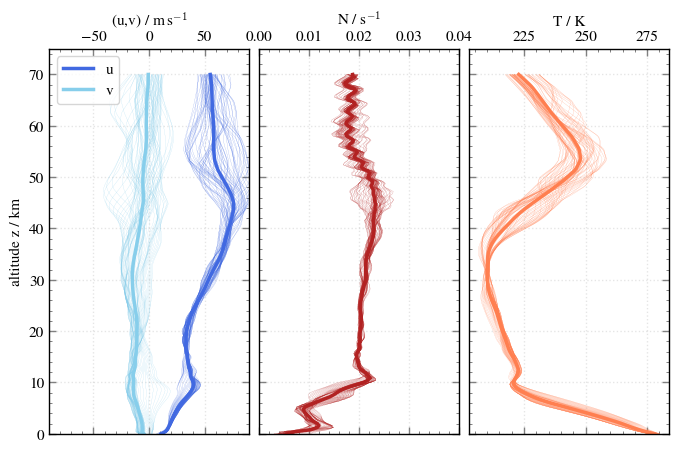

In [10]:
"""Vis env"""
# fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection': ccrs.LambertConformal()})
fig, axes = plt.subplots(1,3, figsize=(8,5),sharey=True, gridspec_kw={"wspace": 0.05, "hspace": 0.05})
ax_wind  = axes[0]
ax_th    = axes[1]
ax_t     = axes[2]

# ax.set_aspect("equal", adjustable='datalim')
"""Wind"""
lws = 0.1
lwl = 2.5
for t in range(len(ds.time)):
    ax_wind.plot(ds["u"][t], ds["level"]/1000, lw=lws, color="royalblue")
    ax_wind.plot(ds["v"][t], ds["level"]/1000, lw=lws, color="skyblue")
ax_wind.plot(dsm["u"], dsm["level"]/1000, lw=lwl, color="royalblue", label="u")
ax_wind.plot(dsm["v"], dsm["level"]/1000, lw=lwl, color="skyblue", label="v")
ax_wind.legend(loc="upper left")

ax_wind.set_xlabel("(u,v) / m$\,$s$^{-1}$")
ax_wind.set_ylabel("altitude z / km")
ax_wind.set_xlim([-90,90])
ax_wind.set_ylim([0,75])
ax_wind.xaxis.set_label_position('top')
ax_wind.xaxis.set_minor_locator(AutoMinorLocator())
ax_wind.yaxis.set_minor_locator(AutoMinorLocator())
ax_wind.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_wind.grid()


"""Theta / N""" #### PLOT STABILITY!!! then check back with EULAG
for t in range(len(ds.time)):
    ax_th.plot(ds["N"][t], ds["level"]/1000, lw=lws, color="firebrick")
ax_th.plot(dsm["N"], dsm["level"]/1000, lw=lwl, color="firebrick")
ax_th.set_xlabel("N / s$^{-1}$")
ax_th.set_xlim([0,0.04])

ax_th.xaxis.set_label_position('top')
ax_th.xaxis.set_minor_locator(AutoMinorLocator())
ax_th.yaxis.set_minor_locator(AutoMinorLocator())
ax_th.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_th.grid()


"""T"""
for t in range(len(ds.time)):
    ax_t.plot(ds["t"][t], ds["level"]/1000, lw=lws, color="coral")
ax_t.plot(dsm["t"], dsm["level"]/1000, lw=lwl, color="coral")
ax_t.set_xlabel("T / K")

ax_t.xaxis.set_label_position('top')
ax_t.xaxis.set_minor_locator(AutoMinorLocator())
ax_t.yaxis.set_minor_locator(AutoMinorLocator())
ax_t.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_t.grid()

"""Save figure"""
folder   = "../data/eulag/figures"
fig_name = "env.png"
fig.savefig(os.path.join(folder,fig_name), facecolor='w', edgecolor='w', format='png', dpi=300, bbox_inches='tight') # orientation='portrait'

In [ ]:
"""Save NETCDF for EULAG"""
ds = xr.open_dataset("../data/eulag/era5_ml_T21_int.nc")
# ds = xr.open_dataset("../data/coral/era5-region/20180618-1644-ml-int.nc")

ds['th'] = ds['t'] * (p0/ds['p'])**(2/7)
# ds = ds.drop(["t","p"])

"""Average and trim"""
ds = ds.mean(dim=["time","latitude","longitude"])

# 151 -> up to 60km
ds = ds.isel(level=slice(0,151)) 

fname = "era5_2018_06_17_upst_t21_l151.nc"
ds.to_netcdf(os.path.join("../data/eulag/env", fname), format='NETCDF3_64BIT') # format='NETCDF3_64BIT', engine='h5netcdf'
ds